In [1]:
from importlib import reload
from load_cluster_data import load_cluster_data
from pca_kmeans_init import pca_kmeans_init
from betabinomo_mix_singlecells import *
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)
import torch
import sklearn.manifold 
import plotnine as p9
import time
# indicate plot should be small 4 by 4
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_violin, theme, element_blank, geom_text
import plotnine
from tqdm import tqdm
plotnine.options.figure_size = (4, 4)
import seaborn as sns
sns.set_theme(style="whitegrid")

/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Settings and Load data

In [2]:
input_file = '/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/clustered_junctions_noanno.txt_anno_free_50_500000_10_5_0.1_single_cell.h5'

# this folder contains input data for each tissue cell type sample
input_files_folder = '/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/Brain/'

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MAKE_PCA_TSNE = True

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

cpu


In [3]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_folder = input_files_folder) 

Reading in data from folder ...
/gpfs/commons/scratch/kisaev/ss_tabulamuris_test/Leaflet/Brain/
Finished reading in data from folder ...
['Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte'
 'Brain_Non-Myeloid_brain_pericyte' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Non-Myeloid_endothelial_cell'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Myeloid_macrophage' 'Brain_Non-Myeloid_Bergmann_glial_cell']
7856
7856
49190
49190
The number of junctions in the data is:  49190
The number of cells in the data is:  7856
The number of cell types in the data is:  9


In [4]:
N = coo_cluster_sparse.shape[0]
J = coo_cluster_sparse.shape[1]

cell_index_tensor, junc_index_tensor, my_data = betabinomo_mix_singlecells.make_torch_data(final_data, **float_type)

/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-lda/betabinomo_mix_singlecells.py:299: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


In [6]:
num_trials = 5 # should also be an argument that gets fed in
num_iters = 30 # should also be an argument that gets fed in
K = 8

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
reload(betabinomo_mix_singlecells)

start_time = time.time()
results = [ betabinomo_mix_singlecells.calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]

# write the above line use fstring
print(f"This took {time.time() - start_time} seconds")

Initialize VI params
Got the initial ELBO ^
ELBO converged @ -3295026688.0  CAVI iteration #  30  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -3296390912.0  CAVI iteration #  14  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -3295738368.0  CAVI iteration #  16  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -3296531200.0  CAVI iteration #  30  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -3295642624.0  CAVI iteration #  13  complete
This took 42.95536541938782 seconds


##### -> why some iterations converge after 20 iterations and some go on for 100 iterations?

### Check how consistently cells get co-assigned together across iterations 

In [7]:
# extract PHI_f from every trial in num_trials
all_iters_PHI_f = [ result[3] for result in results ]
i = 0

# Create an empty list to store DataFrames from each iteration
dfs_list = []

for PHI_var in all_iters_PHI_f:

    probability_tensor = PHI_var

    # Create an array with cell IDs (e.g., cell_0, cell_1, ..., cell_(N-1))
    cell_ids = np.arange(probability_tensor.shape[0])
    cell_ids = [cell_id for cell_id in cell_ids]

    # Get the cluster IDs for each cell based on the maximum probability
    cluster_ids = np.argmax(probability_tensor, axis=1)

    # Create a DataFrame with the cell_id, cluster_id, and probability columns
    df = pd.DataFrame({"cell_id": cell_ids, "cluster_id": cluster_ids})

    # Add column with iteration number
    df["iteration"] = i
    i += 1
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate all the DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs_list, ignore_index=True)

In [8]:
# initiate list to save results for each iteration

all_iters_results = [None] * num_trials

for trial in range(num_trials):
    # Find the unique clusters for each cell_id
    cell_by_cell_matrix = np.zeros((N, N))

    clusters = concatenated_df.loc[concatenated_df["iteration"] == trial, ["cell_id", "cluster_id"]]
    unique_clusters = clusters.set_index('cell_id')['cluster_id'].to_dict()

    # Fill the cell_by_cell_matrix using numpy indexing
    for cell_id, cluster_id in unique_clusters.items():
        cell_by_cell_matrix[cell_id, cell_id] = 1
        same_cluster_cells = clusters[clusters["cluster_id"] ==  cluster_id].cell_id.values
        cell_by_cell_matrix[cell_id, same_cluster_cells] = 1

    all_iters_results[trial] = cell_by_cell_matrix

In [9]:
# get all pairs of num_trials 
import itertools
all_pairs = list(itertools.combinations(range(num_trials), 2))
# Create an empty list to store DataFrames from each iteration
dfs_list = []

for pair in tqdm(all_pairs):
    ## assess similarity between iterations
    x = (all_iters_results[pair[0]] - all_iters_results[pair[1]])
    unique, counts = np.unique(x, return_counts=True)
    # turn unique, counts into dataframe 
    df = pd.DataFrame({'unique': unique, 'counts': counts})
    # get percentage for counts 
    df['percentage'] = df['counts']/df['counts'].sum()
    df["pair"] = str(pair)
    dfs_list.append(df)

# Concatenate all the DataFrames into a single DataFrame
concatenated_iters_comp = pd.concat(dfs_list, ignore_index=True)

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


In [10]:
concatenated_iters_comp = concatenated_iters_comp[["unique", "pair", "percentage"]]

# turn into wide format for plotting heatmap
concatenated_iters_comp_wide = concatenated_iters_comp.pivot(index='pair', columns='unique', values='percentage')

In [11]:
concatenated_iters_comp.sort_values(by=['percentage'], inplace=True, ascending=False)

print(f"The minimum percentage of matching cell pairs across all trials is {concatenated_iters_comp[concatenated_iters_comp['unique'] == 0]['percentage'].min().round(2)}")

The minimum percentage of matching cell pairs across all trials is 0.78


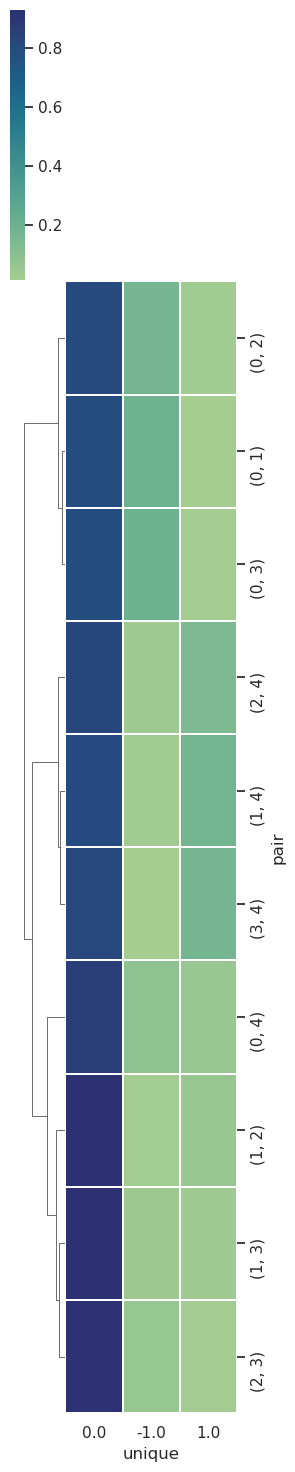

In [12]:
#concatenated_iters_comp

# use seaborn to plot the results, x-axis can be the pair and y-axis can be the value in the unique column 
g = sns.clustermap(concatenated_iters_comp_wide, cmap="crest", linewidth=.1, figsize=(3, 15), yticklabels=1)
g.ax_col_dendrogram.remove()

### Evaluate the learned posterions

The trial with the highest ELBO was 0
    unique    pair  percentage
10     0.0  (0, 4)    0.860028
4      0.0  (0, 2)    0.804325
1      0.0  (0, 1)    0.795615
7      0.0  (0, 3)    0.782738
The pair with the highest percentage overlap is (1, 3)
The highest percentage overlap across pairs was 0.929


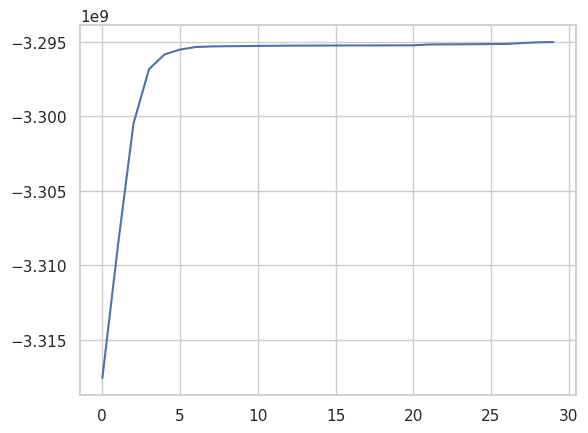

In [13]:
best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
print(f"The trial with the highest ELBO was {best}")

# print rows that contains best in the pair and only where unique == 0
best_res_comp = (concatenated_iters_comp[concatenated_iters_comp.pair.str.contains(str(best))])
print(best_res_comp[best_res_comp['unique'] == 0])

print(f"The pair with the highest percentage overlap is {concatenated_iters_comp.iloc[0].pair}")
print(f"The highest percentage overlap across pairs was {concatenated_iters_comp.iloc[0].percentage.round(3)}")

ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()

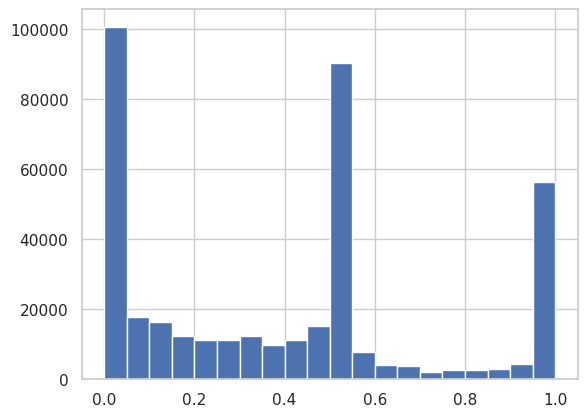

In [14]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)    
plt.hist(juncs_probs.cpu().numpy().flatten(), 20); plt.show()

In [15]:
theta_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
print(theta_f_plot_summ)

                                                         0         1  \
cell_id                                                                
Brain_Myeloid_macrophage                          0.000000  0.983607   
Brain_Myeloid_microglial_cell                     0.502823  0.495129   
Brain_Non-Myeloid_Bergmann_glial_cell             0.000000  0.025000   
Brain_Non-Myeloid_astrocyte                       0.000000  0.004630   
Brain_Non-Myeloid_brain_pericyte                  0.000000  0.000000   
Brain_Non-Myeloid_endothelial_cell                0.006993  0.001399   
Brain_Non-Myeloid_neuron                          0.007117  0.000000   
Brain_Non-Myeloid_oligodendrocyte                 0.006989  0.010802   
Brain_Non-Myeloid_oligodendrocyte_precursor_cell  0.000000  0.000000   

                                                         2         3  \
cell_id                                                                
Brain_Myeloid_macrophage                          0.016393  0.0

In [16]:
GAMMA_f

tensor([2228.4048, 2257.5977,  868.0000,  294.0000,  280.9973,  874.9665,
         507.9974,  552.0362])

In [17]:
np.random.dirichlet(GAMMA_f, 10)

array([[0.28164451, 0.2842416 , 0.1097886 , 0.04140052, 0.03429849,
        0.11094563, 0.06337237, 0.07430829],
       [0.28694921, 0.27850974, 0.10777593, 0.03939837, 0.03752793,
        0.1152945 , 0.06243404, 0.07211029],
       [0.28056506, 0.29073899, 0.11237791, 0.03609192, 0.03228904,
        0.11728767, 0.0625747 , 0.06807471],
       [0.28698013, 0.28708674, 0.10556767, 0.03664924, 0.03837752,
        0.11011996, 0.06946047, 0.06575827],
       [0.27850144, 0.2868556 , 0.1062232 , 0.03967348, 0.0371637 ,
        0.11643566, 0.06381542, 0.07133151],
       [0.27466053, 0.29451723, 0.11656583, 0.03943756, 0.03674502,
        0.10923913, 0.06150814, 0.06732656],
       [0.28247617, 0.28537376, 0.10609415, 0.03728721, 0.03809707,
        0.11297779, 0.06328046, 0.0744134 ],
       [0.27635808, 0.2864866 , 0.11230942, 0.0393625 , 0.03417674,
        0.11667724, 0.06205064, 0.07257877],
       [0.28422164, 0.28321837, 0.10932519, 0.03821809, 0.03258628,
        0.11525018, 0.066365

In [18]:
GAMMA_f / GAMMA_f.sum()

tensor([0.2834, 0.2871, 0.1104, 0.0374, 0.0357, 0.1113, 0.0646, 0.0702])

In [19]:
# How much each cell state is used 
#latent proportions describe the general prevalence of each cluster in the datasetN
# cluster proportions via theta ~ dirichlet(GAMMA_f)
# each cell gets an assignment to a cluster via z_c | theta ~ categorical(theta)

theta = GAMMA_f / GAMMA_f.sum()
theta = theta.cpu().numpy()
theta_sorted = np.sort(theta)
theta_sorted

array([0.03573211, 0.03738556, 0.06459784, 0.0701979 , 0.1103764 ,
       0.11126228, 0.28336787, 0.28708008], dtype=float32)

In [20]:
PHI_f #<- this is the matrix of probabilities of each cell belonging to each cluster

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

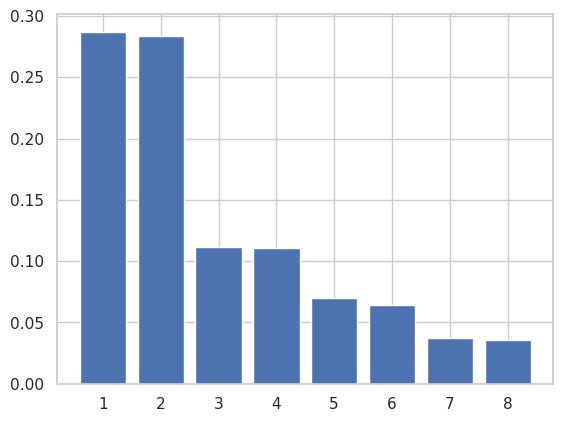

In [21]:
plt.bar(np.arange(K)+1,theta_sorted[::-1]); plt.show()

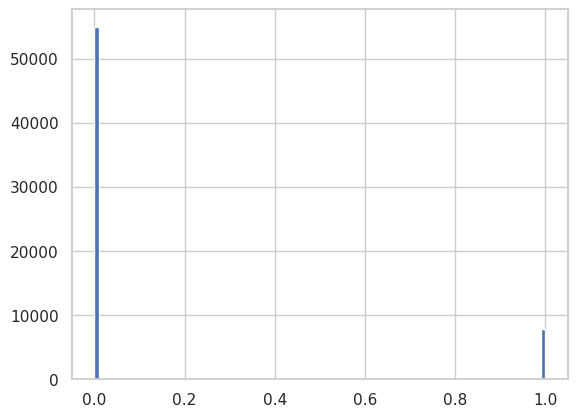

In [22]:
to_keep = theta > 0.01

x = PHI_f.cpu().numpy()
x = x[:,to_keep]
#x -= x.mean(1,keepdims=True)
#x /= x.std(1,keepdims=True)
_ = plt.hist(x.flatten(),100)

col_0                                                0     1    2    3    4  \
cell_type                                                                     
Brain_Myeloid_macrophage                             0    60    1    0    0   
Brain_Myeloid_microglial_cell                     2210  2175    1    1    1   
Brain_Non-Myeloid_Bergmann_glial_cell                0     1    0    1    0   
Brain_Non-Myeloid_astrocyte                          0     2    2    1    8   
Brain_Non-Myeloid_brain_pericyte                     0     0  156    0    0   
Brain_Non-Myeloid_endothelial_cell                   5     1  691    4    4   
Brain_Non-Myeloid_neuron                             2     0    2  264    5   
Brain_Non-Myeloid_oligodendrocyte                   11    17   14   22   62   
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     0     0    0    0  200   

col_0                                               5    6    7  
cell_type                                                       

<Figure size 1000x800 with 0 Axes>

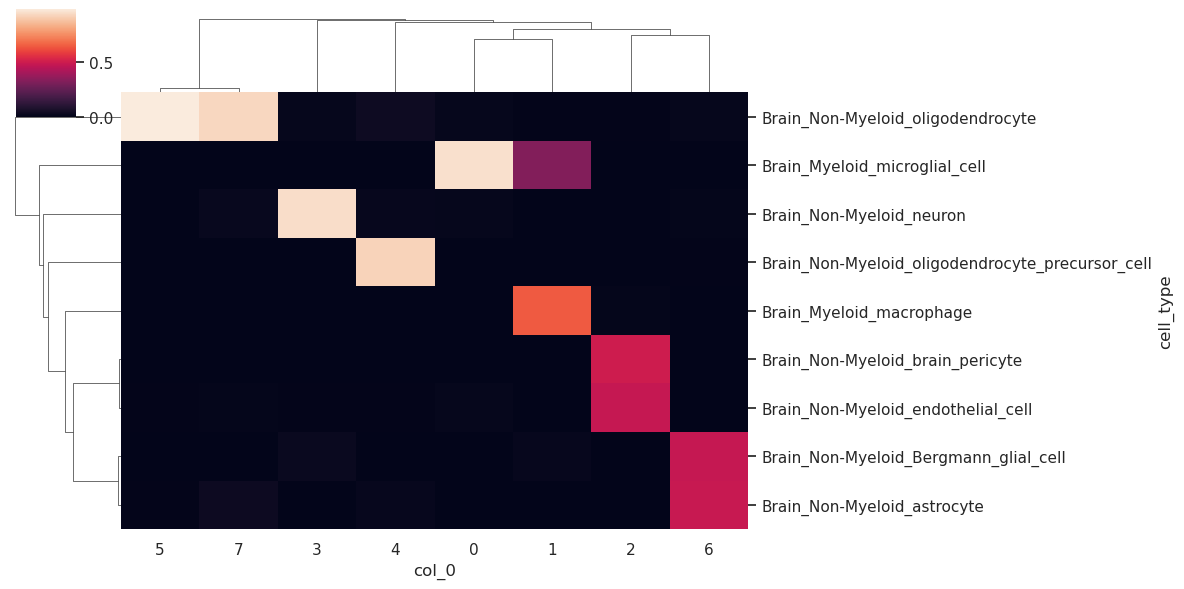

In [23]:
ct = pd.crosstab(cell_ids_conversion["cell_type"], x.argmax(axis=1) )
print(ct)

ct_np = ct.to_numpy()
print(ct_np)

ct_np = ct_np / ct_np.sum(1, keepdims=True) # normalize cell-type counts
print(ct_np)

ct_np = ct_np / ct_np.sum(0, keepdims=True)
print(ct_np)

ct.iloc[:,:] = ct_np

ax = plt.figure(figsize=[10,8])
sns.clustermap(ct, dendrogram_ratio=0.15, vmin = None, figsize=(12,6), annot = False)

In [24]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
# add "cell_state" to each column name 
juncs_probs_df.columns = ["cell_state_" + str(col) for col in juncs_probs_df.columns]
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values

def plot_juncObsUsage(junc_index):

    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]

    # get data for just junc_index 
    junc_dat=final_data[final_data.junction_id_index==junc_index]
    print(junc_dat.cell_type.value_counts())

    # make violin plot for junc_dat junction usage ratio coloured by cell_type and rotate plot 90 degrees
    plot = ggplot(junc_dat, aes(x='cell_type', y='juncratio', fill="cell_type")) + geom_violin() + geom_point() + plotnine.labels.ggtitle(junc_id) + plotnine.coords.coord_flip() 

    # add number of cells in each cell_type to plot 
    print(plot)

def plot_juncProbs(junc_index):
    
    # print junction ID using junction_ids_conversion
    print(junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index])
    junc_id = junction_ids_conversion[junction_ids_conversion["junction_id_index"] == junc_index].junction_id.values[0]
    
    # get data for just junc_index 
    junc_dat=juncs_probs_df[juncs_probs_df.junction_id_index==junc_index]
    junc_dat = junc_dat.melt().iloc[0:K]
    junc_dat.value = junc_dat.value.astype(float)
    # make violin plot for junc_dat junction usage ratio coloured by cell_type
    # don't print x-axis tick labels 
    plot = ggplot(junc_dat, aes(x='variable', y='value')) + geom_point() + theme(axis_text_x=element_blank())
    print(plot)

In [25]:
# calculate sd deviation for each junction for cell states 0 to 19 
juncs_probs_df["sd"] = juncs_probs_df.iloc[:,0:K].std(axis=1)

In [26]:
# write function that takes in cell state and returns top 10 junctions with the highest difference with all other K-1 cell states
def top10_juncs(cell_state):
    # for each junction get the difference between cell_state and all other cell states not including cell_state
    # return top 10 junctions with highest difference
    no_ref=juncs_probs_df[juncs_probs_df.columns[~juncs_probs_df.columns.isin([cell_state, "junction_id_index", "junction_id", "sd"])]]
    juncs_probs_df["diff"] = juncs_probs_df[cell_state] - no_ref.mean(axis=1)
    top10 = juncs_probs_df.sort_values(by="diff", ascending=False).head(10)
    return(top10.junction_id_index.values)

    # think of actually using the distributions... use the full beta distribution via KL divergence... (pairwise)
    # are the distributions across cell states for junctions more different than if they were coming from the same cell state

In [27]:
def log_beta(a, b):
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a + b)

def score(a, b):
    return log_beta(a,b).sum() - log_beta(a.sum(), b.sum())

In [32]:
ALPHA_f.shape

torch.Size([49190, 8])

array([[<Axes: title={'center': 'score'}>]], dtype=object)

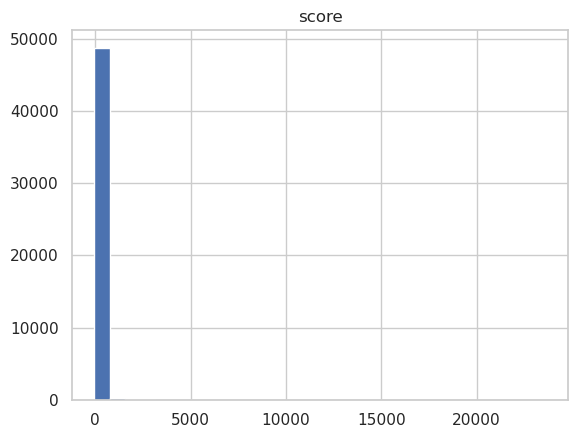

In [33]:
# get likelihood ratio/bayes factor score for ALL junctions 
# let's compare just state X and Y

scores_all_juncs = []
for junc_index in range(juncs_probs.shape[0]):
    a = ALPHA_f[junc_index, [3,7]]
    b = PI_f[junc_index, [3,7]]
    scores_all_juncs.append(score(a, b).item())

# turn scores_all_juncs into dataframe and add junction_id_index as a column
scores_all_juncs_df = pd.DataFrame(scores_all_juncs, columns = ["score"])
scores_all_juncs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
scores_all_juncs_df.sort_values(by="score", ascending=False).head(10)
juncs_test=scores_all_juncs_df.sort_values(by="score", ascending=False).head(10).junction_id_index.values
scores_all_juncs_df.hist(column="score", bins=30)

      junction_id_index          junction_id  Cluster
3130              32393  4_44025560_44032400    30032
Brain_Myeloid_microglial_cell                       3243
Brain_Non-Myeloid_oligodendrocyte                    868
Brain_Non-Myeloid_endothelial_cell                   338
Brain_Non-Myeloid_neuron                             219
Brain_Non-Myeloid_astrocyte                          152
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     128
Brain_Non-Myeloid_brain_pericyte                     107
Brain_Myeloid_macrophage                              43
Brain_Non-Myeloid_Bergmann_glial_cell                 21
Name: cell_type, dtype: int64


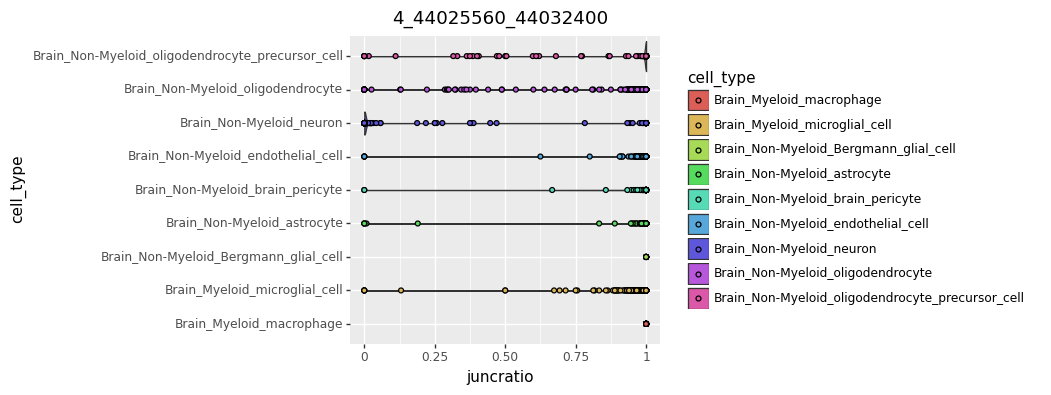


      junction_id_index          junction_id  Cluster
3130              32393  4_44025560_44032400    30032


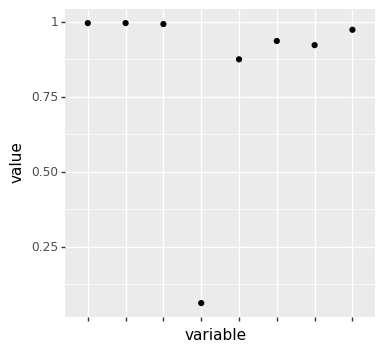


     junction_id_index            junction_id  Cluster
627              31282  4_137321192_137328712    37746
Brain_Myeloid_microglial_cell                       3648
Brain_Non-Myeloid_oligodendrocyte                   1345
Brain_Non-Myeloid_endothelial_cell                   621
Brain_Non-Myeloid_neuron                             247
Brain_Non-Myeloid_astrocyte                          244
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     185
Brain_Non-Myeloid_brain_pericyte                     143
Brain_Myeloid_macrophage                              53
Brain_Non-Myeloid_Bergmann_glial_cell                 28
Name: cell_type, dtype: int64


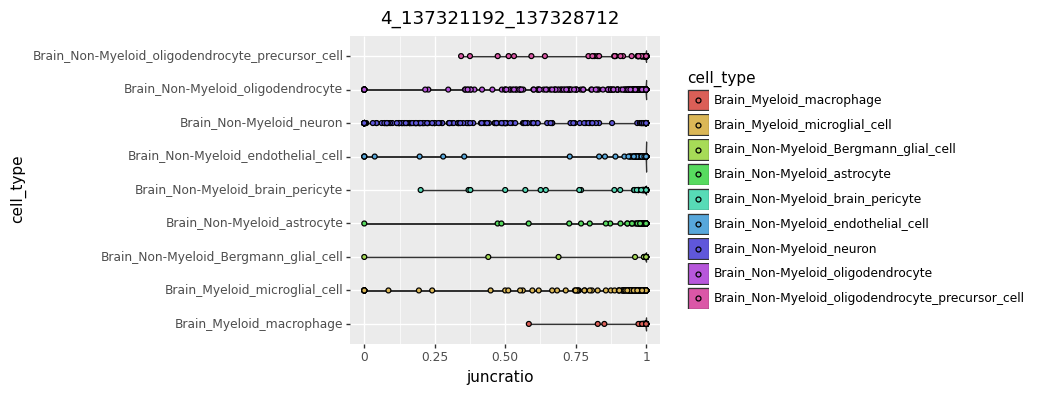


     junction_id_index            junction_id  Cluster
627              31282  4_137321192_137328712    37746


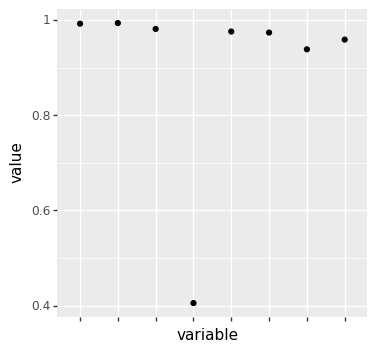


      junction_id_index           junction_id  Cluster
1422               1049  10_60296002_60299097    83091
Brain_Myeloid_microglial_cell                       4364
Brain_Non-Myeloid_oligodendrocyte                   1469
Brain_Non-Myeloid_endothelial_cell                   623
Brain_Non-Myeloid_astrocyte                          412
Brain_Non-Myeloid_neuron                             254
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     202
Brain_Non-Myeloid_brain_pericyte                     152
Brain_Myeloid_macrophage                              59
Brain_Non-Myeloid_Bergmann_glial_cell                 39
Name: cell_type, dtype: int64


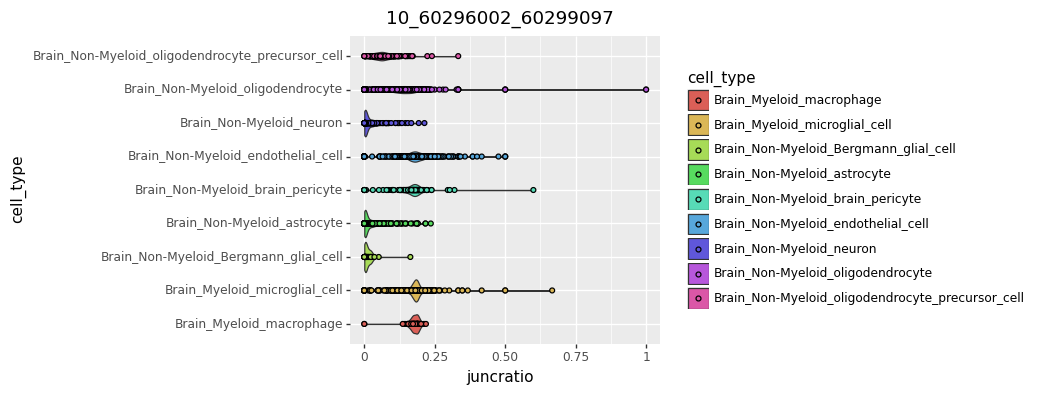


      junction_id_index           junction_id  Cluster
1422               1049  10_60296002_60299097    83091


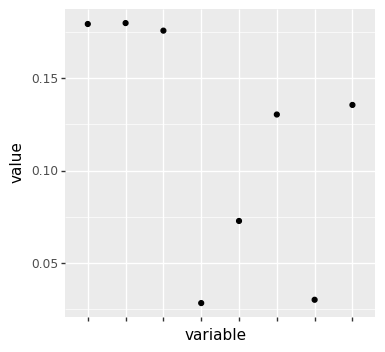


     junction_id_index            junction_id  Cluster
628              31283  4_137322619_137328712    37746
Brain_Myeloid_microglial_cell                       3648
Brain_Non-Myeloid_oligodendrocyte                   1345
Brain_Non-Myeloid_endothelial_cell                   621
Brain_Non-Myeloid_neuron                             247
Brain_Non-Myeloid_astrocyte                          244
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     185
Brain_Non-Myeloid_brain_pericyte                     143
Brain_Myeloid_macrophage                              53
Brain_Non-Myeloid_Bergmann_glial_cell                 28
Name: cell_type, dtype: int64


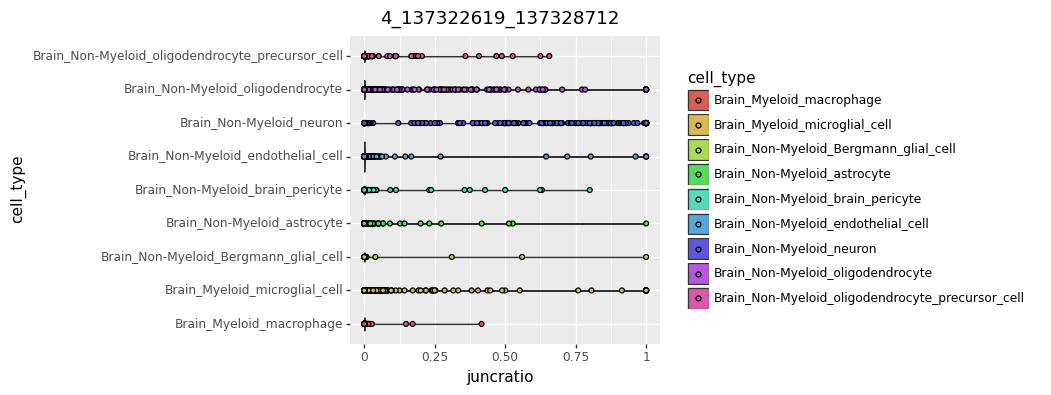


     junction_id_index            junction_id  Cluster
628              31283  4_137322619_137328712    37746


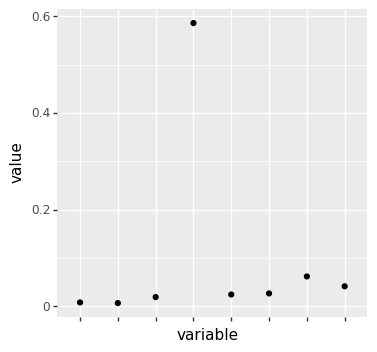


      junction_id_index           junction_id  Cluster
1715               7159  12_55111181_55112799   101805
Brain_Non-Myeloid_oligodendrocyte                   1397
Brain_Myeloid_microglial_cell                        874
Brain_Non-Myeloid_endothelial_cell                   416
Brain_Non-Myeloid_neuron                             205
Brain_Non-Myeloid_astrocyte                          163
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     138
Brain_Non-Myeloid_brain_pericyte                     120
Brain_Myeloid_macrophage                              21
Brain_Non-Myeloid_Bergmann_glial_cell                 14
Name: cell_type, dtype: int64


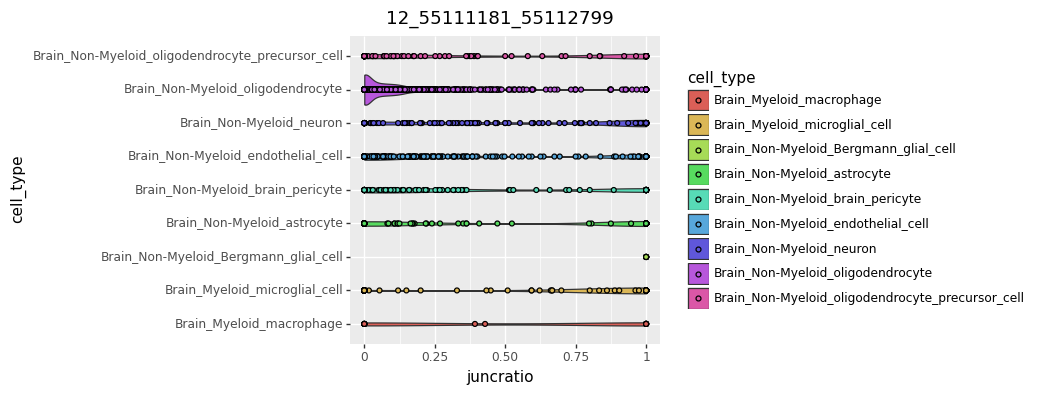


      junction_id_index           junction_id  Cluster
1715               7159  12_55111181_55112799   101805


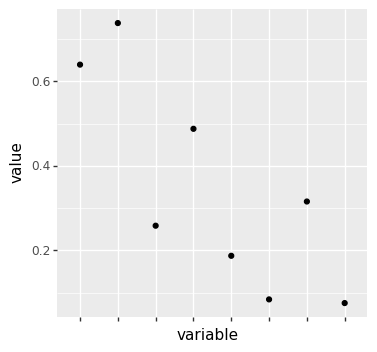


          junction_id_index            junction_id  Cluster
11955175              48388  X_166384000_166386951   145518
Brain_Non-Myeloid_oligodendrocyte                   1455
Brain_Non-Myeloid_astrocyte                          373
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     197
Brain_Non-Myeloid_neuron                             160
Brain_Non-Myeloid_Bergmann_glial_cell                 36
Brain_Non-Myeloid_endothelial_cell                    36
Name: cell_type, dtype: int64


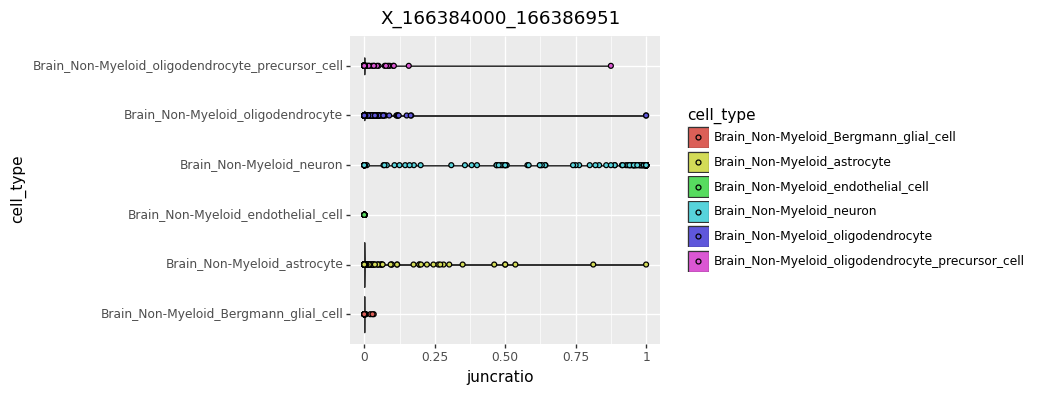


          junction_id_index            junction_id  Cluster
11955175              48388  X_166384000_166386951   145518


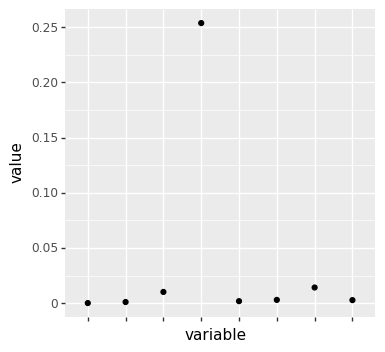


      junction_id_index          junction_id  Cluster
4186              46862  9_59672073_59675028    74915
Brain_Myeloid_microglial_cell                       2525
Brain_Non-Myeloid_oligodendrocyte                   1196
Brain_Non-Myeloid_endothelial_cell                   615
Brain_Non-Myeloid_astrocyte                          353
Brain_Non-Myeloid_neuron                             257
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     193
Brain_Non-Myeloid_brain_pericyte                     143
Brain_Myeloid_macrophage                              46
Brain_Non-Myeloid_Bergmann_glial_cell                 30
Name: cell_type, dtype: int64


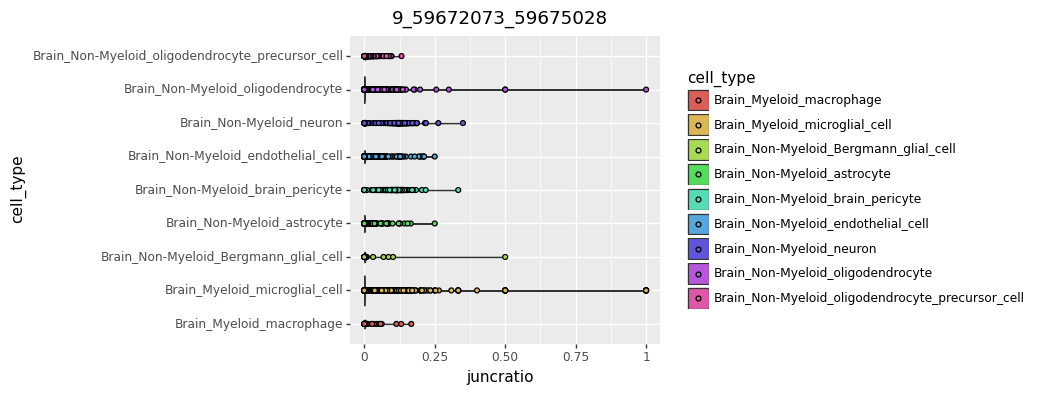


      junction_id_index          junction_id  Cluster
4186              46862  9_59672073_59675028    74915


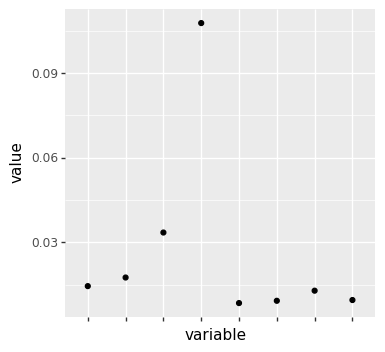


      junction_id_index           junction_id  Cluster
1724               7180  12_55186241_55187859   101813
Brain_Non-Myeloid_oligodendrocyte                   1397
Brain_Myeloid_microglial_cell                        874
Brain_Non-Myeloid_endothelial_cell                   416
Brain_Non-Myeloid_neuron                             205
Brain_Non-Myeloid_astrocyte                          163
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     138
Brain_Non-Myeloid_brain_pericyte                     120
Brain_Myeloid_macrophage                              21
Brain_Non-Myeloid_Bergmann_glial_cell                 14
Name: cell_type, dtype: int64


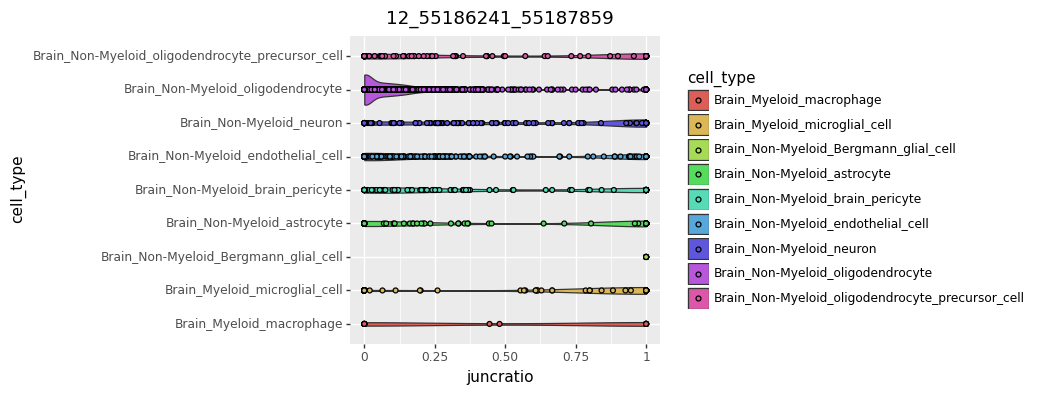


      junction_id_index           junction_id  Cluster
1724               7180  12_55186241_55187859   101813


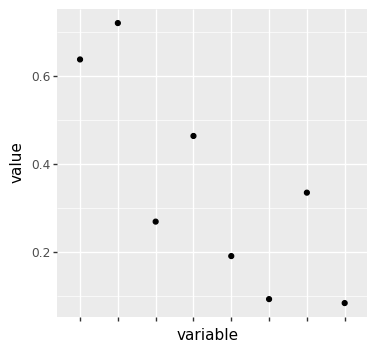


      junction_id_index             junction_id  Cluster
6570                430  10_128491033_128492058    89130
Brain_Myeloid_microglial_cell                       2472
Brain_Non-Myeloid_oligodendrocyte                   1377
Brain_Non-Myeloid_endothelial_cell                   713
Brain_Non-Myeloid_astrocyte                          293
Brain_Non-Myeloid_neuron                             259
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     183
Brain_Non-Myeloid_brain_pericyte                     155
Brain_Myeloid_macrophage                              55
Brain_Non-Myeloid_Bergmann_glial_cell                 30
Name: cell_type, dtype: int64


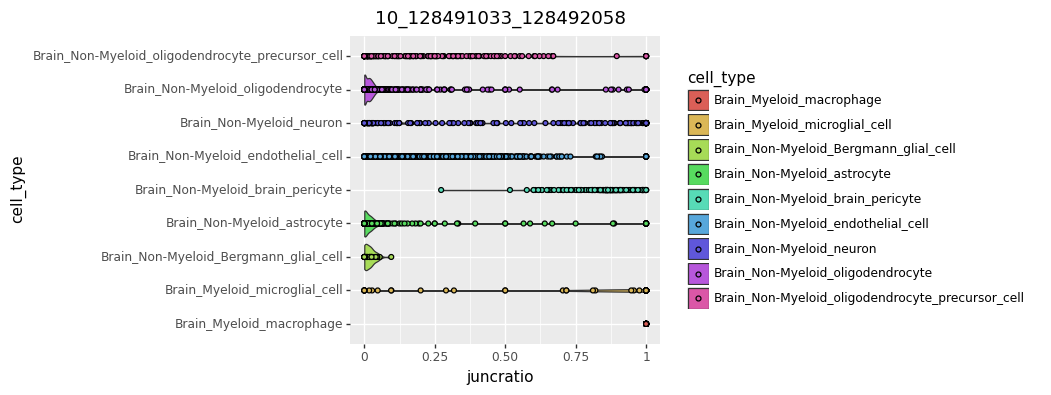


      junction_id_index             junction_id  Cluster
6570                430  10_128491033_128492058    89130


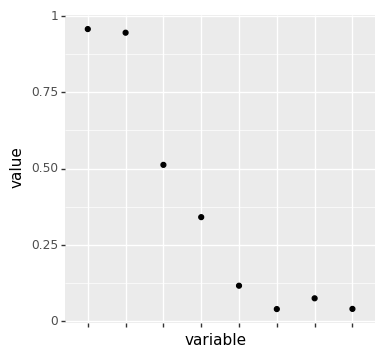


      junction_id_index           junction_id  Cluster
5250              14308  16_49906812_49910868   124458
Brain_Myeloid_microglial_cell                       1930
Brain_Non-Myeloid_oligodendrocyte                   1160
Brain_Non-Myeloid_endothelial_cell                   371
Brain_Non-Myeloid_astrocyte                          232
Brain_Non-Myeloid_neuron                             206
Brain_Non-Myeloid_oligodendrocyte_precursor_cell     147
Brain_Non-Myeloid_brain_pericyte                      69
Brain_Myeloid_macrophage                              35
Brain_Non-Myeloid_Bergmann_glial_cell                 20
Name: cell_type, dtype: int64


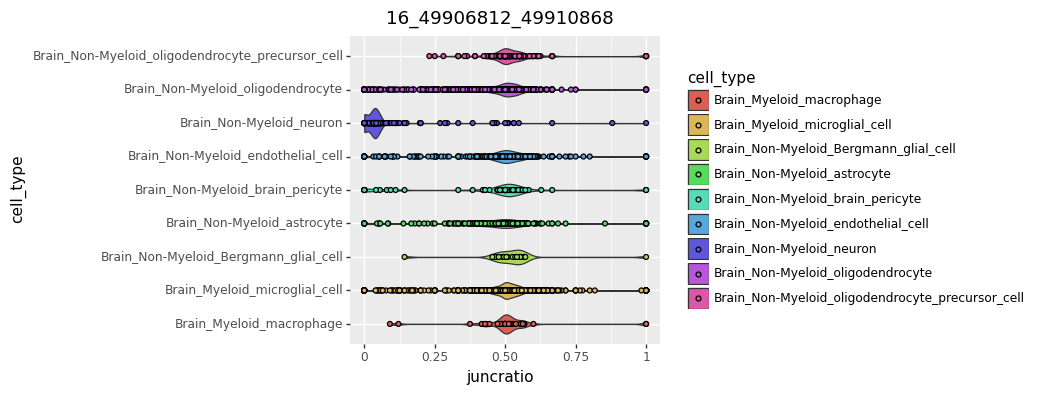


      junction_id_index           junction_id  Cluster
5250              14308  16_49906812_49910868   124458


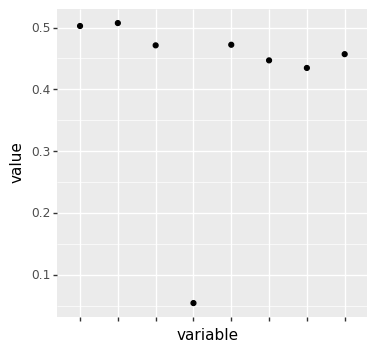

In [34]:
# for each junction in top10juncs_state1, run plot_juncObsUsage and plot_juncProbs
for junc in juncs_test:
    plot_juncObsUsage(junc)
    plot_juncProbs(junc)